<img src="https://www.anped.org.br/sites/default/files/images/ufcg-lateral.png" width="780" height="240" align="center"/>

## Centro de Engenharia Elétrica e Informática
## Departamento de Engenharia Elétrica
## Disciplina: <span style="color:red">Int. ao Processamento de Imagem Digital e Visão Computacional</span>
## Professora: <span style="color:red">Luciana Veloso</span>

# <span style="color:red">Laboratório 8.2: Ajuste Fino</span>
***

### Importação dos Pacotes

In [6]:
import os                                # operational system para manipulação de arquivos.
import cv2                               # opencv para manipulação de imagens.
import random
import numpy as np                       # numpy para manipulação de matrizes e arrays
import matplotlib.pyplot as plt          # pyplot para plotagem de gráficos e imagens
import zipfile                           # zipfile para lidar com arquivos compactados
import urllib.request as url             # urllib para baixar arquivos via HTTPS
from tensorflow.keras import layers      # módulo de camadas do keras
from tensorflow.keras import callbacks   # módulo de callbacks do keras
from tensorflow.keras import optimizers  # módulo de otimizadores do keras
# classe de modelos sequenciais para construir as redes neurais
from tensorflow.keras.models import Sequential   
# classe de modelos sequenciais para construir as redes neurais
from tensorflow.keras.applications import VGG16  

# gerador de dados do keras, utilizado para carregar imagens em tempo de execução
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# método para importar modelos gerados pelo tensorflow
from tensorflow.keras.models import load_model

In [2]:
# extraindo a base de dados do arquivo compactado
url.urlretrieve('https://github.com/Alyssonmach/pdi-labs/raw/main/data.zip', 
                'data.zip')
url.urlretrieve('https://github.com/Alyssonmach/pdi-labs/raw/main/model.h5', 
                'model.h5')
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

### Dados de Experimento

* Vamos utilizar o banco de dados Cats vs Dogs, que foi utilizado no Desafio Prático;

* Cada instância do banco de dados corresponde a uma imagem rotulada de um Cachorro ou um Gato;

* As imagens do banco de dados são coloridas e foram redimensionadas para 150x150;

* Imagens de Cachorro têm rótulo 0 e as de Gato têm rótulo 1;

* A versão que estamos usando tem 3000 imagens, 2000 para treino, 500 para validação e 500 para teste;

* Todas as partições da base de dados são balanceadas;

### Carregando os Dados em Tempo Real

O Keras disponibiliza um objeto ImageDataGenerator para o carregamento de dados em tempo real durante o treinamento de modelos. São necessárias duas etapas para configurar o objeto:

1. Definição das transformações realizadas sobre os dados, ao instanciar o ImageDataGenerator propriamente dito:
    * Isso pode ser feito a partir de **datagen = ImageDataGenerator( rescale = 1./255 )**
    * Nesse exemplo o único parâmetro setado é o rescale, que define uma constante para normalizar as imagens carregadas.
    * Outras transformações podem ser especificadas utilizando outros parâmetros;
2. Definição do método de carregamento:
    * Os dados podem ser carregados com base em uma estrutura de diretórios ou a partir de um dataframe;
    * Vamos utilizar o método **flow_from_directory** para carregar os dados com base na estrutura de dados montada;
    * A chamada do método se faz a partir de **generator = datagen.flow_from_directory( data_dir, target_size, batch_size, class_mode)**
        * generator é um objeto de fornece exemplos continuamente a não ser que seja explicitamente encerrado ( while(True) );
        * data_dir é o diretório raiz dos dados, dentro dessa pasta os exemplos devem estar divididos por classe em pastas distintas;
        * target_size é uma tupla que especifica o tamanho das imagens carregadas;
        * class_mode define como os gabaritos são carregados, se **"binary"** carrega os gabaritos como inteiros 0 ou 1, se **"categorical"** carrega gabaritos categóricas conforme usadas no Exp. 7, se **None** não carrega gabaritos;

In [3]:
val_datagen   = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_directory(os.path.join(".", "data", "val"), target_size = (150, 150),
                                                 batch_size  = 20, class_mode  = "binary")

# Atributo do generator que fornece o número de amostras detectadas
val_samples = val_generator.samples 
print(val_samples, "amostras detectadas")

# Atributo do generator que fornece o mapeamento de classe para índice 
# Repare que os índices são definidos pelo generator com base nos diretórios de arquivos em ordem alfabética
class_to_idx_dict = val_generator.class_indices
print( "Mapeamento Classes -> Índices:", class_to_idx_dict )

# Construção de um novo dicionário que inverte o mapeamento
idx_to_class_dict = { v: k for k, v in class_to_idx_dict.items() }
print( "Mapeamento Índices -> Classes:", idx_to_class_dict )

Found 1000 images belonging to 2 classes.
1000 amostras detectadas
Mapeamento Classes -> Índices: {'Cachorro': 0, 'Gato': 1}
Mapeamento Índices -> Classes: {0: 'Cachorro', 1: 'Gato'}


### Aumento de Dados

Outras transformações possíveis no ImageDataGenerator viabilizam o aumento de dados. Nesse sentido, é possível definir transformações aleatórias que são realizadas conforme os dados são carregados para simular um banco de dados maior.

* Exemplos de transformações aleatórias são:
    * rotation_range valor que define o valor máximo (em graus) das rotações aleatórias realizadas;
    * width_shift_range valor (em fração) que determina o valor máximo de uma translação horizontal realizada com base na largura da imagem;
    * height_shift_range valor (em fração) que determina o valor máximo de uma translação vertical realizada com base na altura da imagem;
    * zoom_range valor (em fração) que determina o maior zoom aleatório realizado na imagem;
    * shear_range valor (em fração) que determina a maior deformação aleatória realizada na imagem;
    * horizontal_flip booleano que determina se reflexões horizontais devem ser aplicadas aleatoriamente na imagem;
    * vertical_flip booleano que determina se reflexões verticais devem ser aplicadas aleatoriamente na imagem;
    * fill_mode modo de preenchimento de buracos provocados pelas transformações realizadas:
        * 'constant': preenche os buracos com um valor constante que pode ser fornecido pelo parâmetro **cval**;
        * 'nearest': preenche os buracos com a repetição dos elementos mais próximos das suas bordas;
        * 'reflect': preenche os buracos com a reflexão dos elementos mais próximos das suas bordas;
        * 'wrap': preenche os buracos considerando a imagem como um sinal periódico;

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,        # normalizando as imagens
    rotation_range = 45,       # Rotação aleatória de até 40°
    width_shift_range = 0.2,   # Translação horizontal de até 20% da largura
    height_shift_range = 0.2,  # Translação vertical de até 20% da altura
    zoom_range = 0.2,          # Zoom aleatório de até 20%
    shear_range = 0.2,         # Deformação de 20%
    horizontal_flip = True,    # Espelhamento horizontal aleatório
    vertical_flip = False,     # Espelhamento vertical aleatório
    fill_mode = "nearest")     # Preenchimentod e buracos pelo pixel mais próximo

train_generator = train_datagen.flow_from_directory(
    os.path.join(".", "data", "train"), target_size = (150, 150),
    batch_size  = 20, class_mode  = "binary")

# Atributo do generator que fornece o número de amostras detectadas
train_samples = train_generator.samples 
print(train_samples)

Found 2000 images belonging to 2 classes.
2000


* A utilização de aumento de dados usando o Image Data Generator do Keras substitui o banco de dados. Esse fato é facilmente observável no número de imagens retornadas pelo gerador com e sem aumento de dados, ambos retornaram as 2000 imagens que foram encontradas no diretório onde os dados estão armazenados. Desse modo, as imagens em sua forma original não serão utilizadas quando se usa aumento de dados, apenas as imagens alteradas nesse tipo procedimento.

### Carregando o Modelo

* Dessa vez vamos carregar o modelo treinado na parte 1 do experimento:
    * **model = load_model(path)**
    * Esse comando carrega todas as informações do modelo treinado, incluindo arquitetura e os pesos

In [7]:
model = load_model("model.h5")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### Acessando Camadas

* No Keras podemos acessar as camadas do modelo individualmente através do atributo **layers** de um modelo, que retorna uma lista das suas camadas. É possível verificar e alterar alguns dos atribudos das camadas, a exemplo de:

    * **layer.input_shape** dimensões do tensor de entrada, "None" indica uma dimensão coringa, que aceita qualquer tamanho;
    * **layer.output_shape** dimensões do tensor de saída, "None" indica uma dimensão coringa, que aceita qualquer tamanho;
    * **layer.trainable** variável booleana que indica se os pesos da camada são treináveis ou não;
    * **layer.name** nome da camada, pode ser modificado a partir do argumento optativo "name" nas funções de todas as camadas;


In [8]:
for layer in model.layers:
    status = "Treinável" if layer.trainable else "Congelada"
    print("Camada '{}' - Status: {} - Entrada: {} - Saída: {}".format(layer.name,
                                                                      status, 
                                                                      layer.input_shape, 
                                                                      layer.output_shape))

Camada 'vgg16' - Status: Treinável - Entrada: (None, 150, 150, 3) - Saída: (None, 4, 4, 512)
Camada 'flatten_4' - Status: Treinável - Entrada: (None, 4, 4, 512) - Saída: (None, 8192)
Camada 'dense_8' - Status: Treinável - Entrada: (None, 8192) - Saída: (None, 256)
Camada 'dense_9' - Status: Treinável - Entrada: (None, 256) - Saída: (None, 1)


Também é possível acessar camadas através da função **get_layer**, que retorna uma camada a partir de uma referência ao seu nome.

* Observe a base convolucional da VGG16 é vista como uma única camada, que do ponto de vista do modelo produzida é uma camada treinável.
* Contudo, quando verificamos as suas camadas internas é possível ver que todas elas estão congeladas.

In [9]:
conv_base = model.get_layer("vgg16")
for layer in conv_base.layers:
    status = "Treinável" if layer.trainable else "Congelada"
    print("Camada '{}' - Status: {} - Entrada: {} - Saída: {}".format(layer.name,
                                                                      status, 
                                                                      layer.input_shape, 
                                                                      layer.output_shape))

Camada 'input_8' - Status: Treinável - Entrada: [(None, 150, 150, 3)] - Saída: [(None, 150, 150, 3)]
Camada 'block1_conv1' - Status: Congelada - Entrada: (None, 150, 150, 3) - Saída: (None, 150, 150, 64)
Camada 'block1_conv2' - Status: Congelada - Entrada: (None, 150, 150, 64) - Saída: (None, 150, 150, 64)
Camada 'block1_pool' - Status: Congelada - Entrada: (None, 150, 150, 64) - Saída: (None, 75, 75, 64)
Camada 'block2_conv1' - Status: Congelada - Entrada: (None, 75, 75, 64) - Saída: (None, 75, 75, 128)
Camada 'block2_conv2' - Status: Congelada - Entrada: (None, 75, 75, 128) - Saída: (None, 75, 75, 128)
Camada 'block2_pool' - Status: Congelada - Entrada: (None, 75, 75, 128) - Saída: (None, 37, 37, 128)
Camada 'block3_conv1' - Status: Congelada - Entrada: (None, 37, 37, 128) - Saída: (None, 37, 37, 256)
Camada 'block3_conv2' - Status: Congelada - Entrada: (None, 37, 37, 256) - Saída: (None, 37, 37, 256)
Camada 'block3_conv3' - Status: Congelada - Entrada: (None, 37, 37, 256) - Saída: (

* As camadas mais do topo na rede neural convolucional são mais  generalistas, pois elas recebem os dados mais semelhante ao seu formato original e extraí características mais gerais presentes na imagem. As camadas mais próximas do final da rede tendem a encontrar características mais intrínsecas da base de dados treinada, sendo ela mais especializada.
* As camadas mais valiosas para o modelo se encontram no quinto bloco, sendo elas:
    * block5_conv1
    * block5_conv2
    * block5_conv3
    * block5_pool
* Essas camadas estão mais próximas da saída da rede em relação as do primeiro bloco, sendo elas as responsáveis por extrair características mais especializadas da imagem.

### Descongelamento das Camadas

No Keras, camadas de uma rede podem ter seus pesos congelados, fazendo com que eles não sejam modificados durante o treinamento. 

* Para fazer isso, basta selecionar uma camada e modificar seu atributo **trainable** para False.
* Em contrapartida, para descongelar uma camada basta alterar o mesmo atributo para True.

In [10]:
# definindo todas as camadas do modelo como treináveis 
model.trainable = True
# obtendo as camadas convolucionais da arquitetura VGG16
conv_base = model.get_layer("vgg16")

# criando uma flag de estado de treinamento e inicializando-a como falsa (estado não treinável) 
set_trainable = False
# para cada uma das camadas convolucionais da VGG16...
for layer in conv_base.layers:
    # se a camada for igual a 'block5_conv2'...
    if layer.name == "block5_conv2":
        # a flag de estado de treinamento muda de estado para estado treinável
        set_trainable = True
    # todas as camadas posteriores a 'block5_conv2' são configuradas como treinável 
    # e as camadas anteriores como não treináveis
    layer.trainable = set_trainable

* É verdade que o ajuste fino funciona melhor com pequenos valores para a taxa de aprendizagem. Isso ocorre porquê geralmente as primeiras camadas estão congeladas e a rede vai tentar extraír as características mais intermediárias e especializadas dos dados, sendo importante que esse aprendizado seja lento para garantir uma boa convergência do modelo ao objetivo proposto. Desse modo, a taxa de aprendizado ajustada com valores pequenos é um hiperparâmetro responsável por garantir essa lenta convergência e consequentemente um melhor ajuste do modelo aos dados de treinamento.

In [11]:
model.compile(optimizer=optimizers.Adam(learning_rate = 1e-5), 
              loss = "binary_crossentropy", 
              metrics = ["acc"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 6,817,281
Non-trainable params: 9,995,072
_________________________________________________________________


### Callbacks

* Dessa vez utilizaremos uma nova callback do Keras, o ReduceLROnPlateau.
* Essa função modifica a taxa de aprendizagem utilizada durante o treinamento caso a variável monitorada deixe de melhorar por um número pré-definido de epochs.
* reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor, factor, patience, verbose)
    * monitor é a variável que deve ser monitorada pelo callback;
    * factor é a constante que deve ser multiplicada pela taxa de aprendizagem atual caso um ajuste seja realizado;
    * patience é o número de epochs sem melhora que devem ocorrer para que um ajuste na taxa de aprendizagem seja realizado;
    * verbose é o modo de texto, 1 indica para que o Keras avise quando um novo modelo for salvo;


In [12]:
model_checkpoint = callbacks.ModelCheckpoint("model_ft.h5", monitor = "val_acc", 
                                             save_best_only = True, verbose = 1)
reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor = "val_acc", factor = 0.75, 
                                                   patience = 3, verbose = 1)

# Repare que ao utilizar mais de 1 callback elas devem ser organizadas em uma lista
callback_list = [model_checkpoint, reduce_lr_on_plateau]

### Ajuste de Pesos

O treinamento é realizado a partir da função **fit**, que recebe dados de treino e de validação além de hiperparâmetros como o número de épocas e o tamanho dos lotes de dados (batchsize). Nesse caso, como estamos utilizando generators, não é preciso fornecer os exemplos e os gabaritos separadamente e nem o batchsize:

* **hist = model.fit( x = None, steps_per_epoch = None, epochs = 1, callbacks = [], validation_data = None, validation_steps = None, verbose = "auto")**
    * x corresponde aos dados de treino, também pode ser um generator;
    * steps_per_epoch corresponde ao número de lotes (batches) que devem ser produzidos com o generator de treino por epoch;
    * epochs corresponde ao número de épocas de treinamento;
    * callbacks corresponde à lista de callbacks utilizada;
    * validation_data corresponde aos dados de validação, também pode ser um generator;
    * validation_steps corresponde ao número de lotes (batches) que devem ser produzidos com o generator de validação por epoch;
    * verbose indica como a função deve reportar os resultados:
        * 0: modo silencioso, nenhum retorno em formato de texto;
        * 1: retorno a cada época e barra de progresso;
        * 2: retorno a cada época sem barra de progresso;
    * hist é um dicionário de retorno com os valores de loss e das métricas computadas para treino e validação;

In [13]:
history = model.fit(train_generator, steps_per_epoch = 100,
                    epochs = 30, callbacks = callback_list, 
                    validation_data = val_generator, validation_steps = 50)

model.load_weights("model_ft.h5")

history_dict = history.history

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.2954 - acc: 0.8705
Epoch 1: val_acc improved from -inf to 0.89300, saving model to model_ft.h5
100/100 [==============================] - 22s 125ms/step - loss: 0.2954 - acc: 0.8705 - val_loss: 0.2375 - val_acc: 0.8930 - lr: 1.0000e-05
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.2731 - acc: 0.8790
Epoch 2: val_acc improved from 0.89300 to 0.90300, saving model to model_ft.h5
100/100 [==============================] - 13s 134ms/step - loss: 0.2731 - acc: 0.8790 - val_loss: 0.2411 - val_acc: 0.9030 - lr: 1.0000e-05
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.2543 - acc: 0.8880
Epoch 3: val_acc improved from 0.90300 to 0.91100, saving model to model_ft.h5
100/100 [==============================] - 12s 124ms/step - loss: 0.2543 - acc: 0.8880 - val_loss: 0.2278 - val_acc: 0.9110 - lr: 1.0000e-05
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 

### Resultados dos Modelos

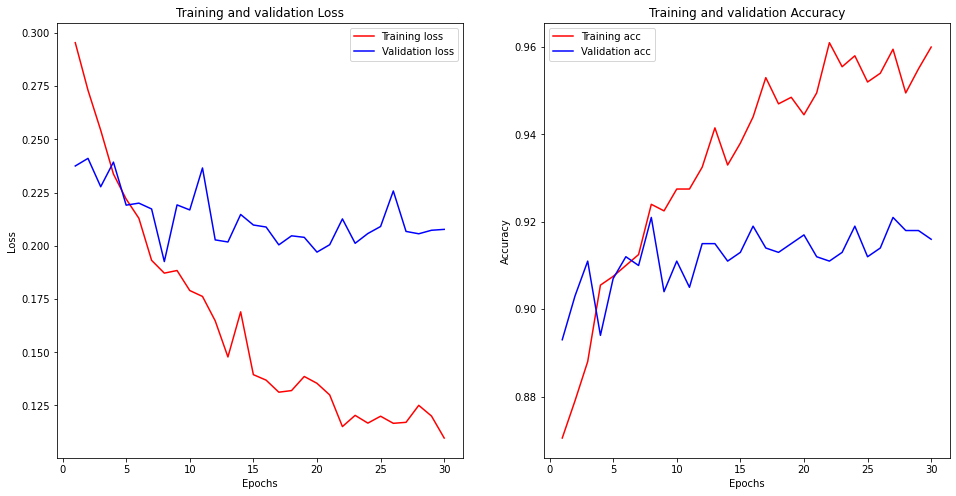

In [14]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16, 8))

# Loss
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, "r", label = "Training loss")
ax.plot(epochs, val_loss_values, "b", label = "Validation loss")
ax.set_title("Training and validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, "r", label = "Training acc")
ax.plot(epochs, val_acc_values, "b", label = "Validation acc")
ax.set_title("Training and validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

### Métricas de Avaliação

O teste do modelo pode ser realizado a partir da função **evaluate**, que também suporta generators.

* Observe que dessa vez utilizou-se o parâmetro "shuffle" no flow_from_directory. Isso foi feito para que os exemplos de teste não fossem embaralhados pelo generator e pudessem ser identificados posteriormente.

In [15]:
test_datagen   = ImageDataGenerator( rescale = 1./255 )
test_generator = test_datagen.flow_from_directory( os.path.join(".", "data", "test"), target_size = (150, 150),
                                                   batch_size  = 1, class_mode  = "binary", 
                                                  shuffle = False)

# Atributo do generator que fornece o número de amostras detectadas
test_samples = test_generator.samples

test_loss, test_acc = model.evaluate( test_generator )

print("Test Accuracy:", 100 * test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(test_samples * test_acc), 
                                       round(test_samples * (1 - test_acc))))

Found 1000 images belonging to 2 classes.
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1985 - acc: 0.9220
Test Accuracy: 92.1999990940094 %
Acertos: 922 - Erros: 78


* O ajuste fino ocorre do final para o começo para que o modelo foque em ajustar os pesos das camadas que extraem características mais especializadas e, em casos de não convergência, as camadas são descongeladas indo em direção ao começo da rede, com o objetivo de obter o melhor ajuste possível com os dados de treinamento, ao passo em que ocorre uma utilização otimizada dos pesos transferidos por transferência de aprendizagem.

### Visualização dos Resultados

In [16]:
def show_results(paths, ytest, ypred, labels, num = 25, tipo = "rand"):
    
    if tipo == "acertos":
        fltr_idx = [i for i in range(ytest.shape[0]) if ypred[i] == ytest[i]]
    else:
        fltr_idx = [i for i in range(ytest.shape[0]) if ypred[i] != ytest[i]]
        
    indices = np.random.choice(fltr_idx, min(num, len(fltr_idx)), replace=False)
       
    rows = int(num/5)
    fig, axs = plt.subplots(nrows = rows, ncols = 5, figsize=(20, 5*rows))
    
    for i, idx in enumerate(indices):
        path = os.path.join(".", "data", "test", paths[idx])
        img = cv2.imread(path)[:,:,::-1]
        if ypred[idx] == ytest[idx]:
            axs[i//5][i%5].set_title(labels[ytest[idx]], color = "green", fontsize = 20)
        else:
            axs[i//5][i%5].set_title("Pred: {}\n Gabarito: {}".format(labels[ypred[idx]], 
                                                                      labels[ytest[idx]]), color = "red", 
                                     fontsize = 20)
        
        axs[i//5][i%5].imshow(img, vmin = 0, vmax = 255, cmap = "gray")
        axs[i//5][i%5].axis('off')
    return

test_generator.reset()
filenames = test_generator.filenames
labels = test_generator.labels

pred_labels = model.predict(test_generator, verbose = 0)
preds = [int(pred[0] > 0.5) for pred in pred_labels]

### Imagens Preditas Corretamente

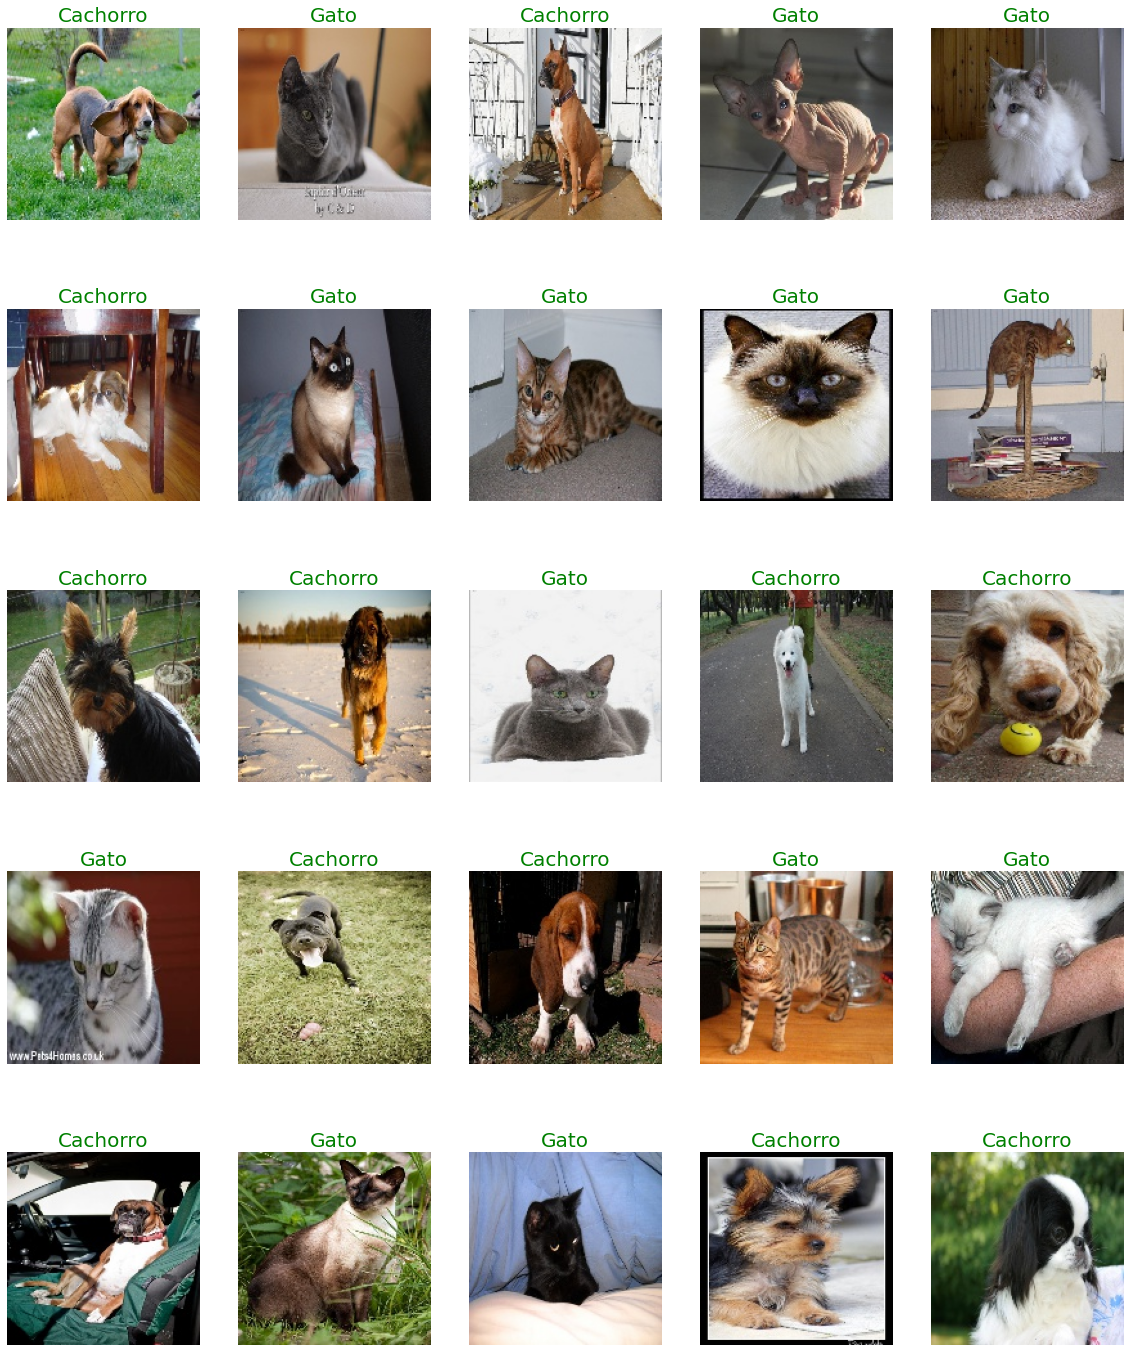

In [17]:
show_results(filenames, labels, preds, idx_to_class_dict, tipo = "acertos")

### Imagens Preditas Erroneamente

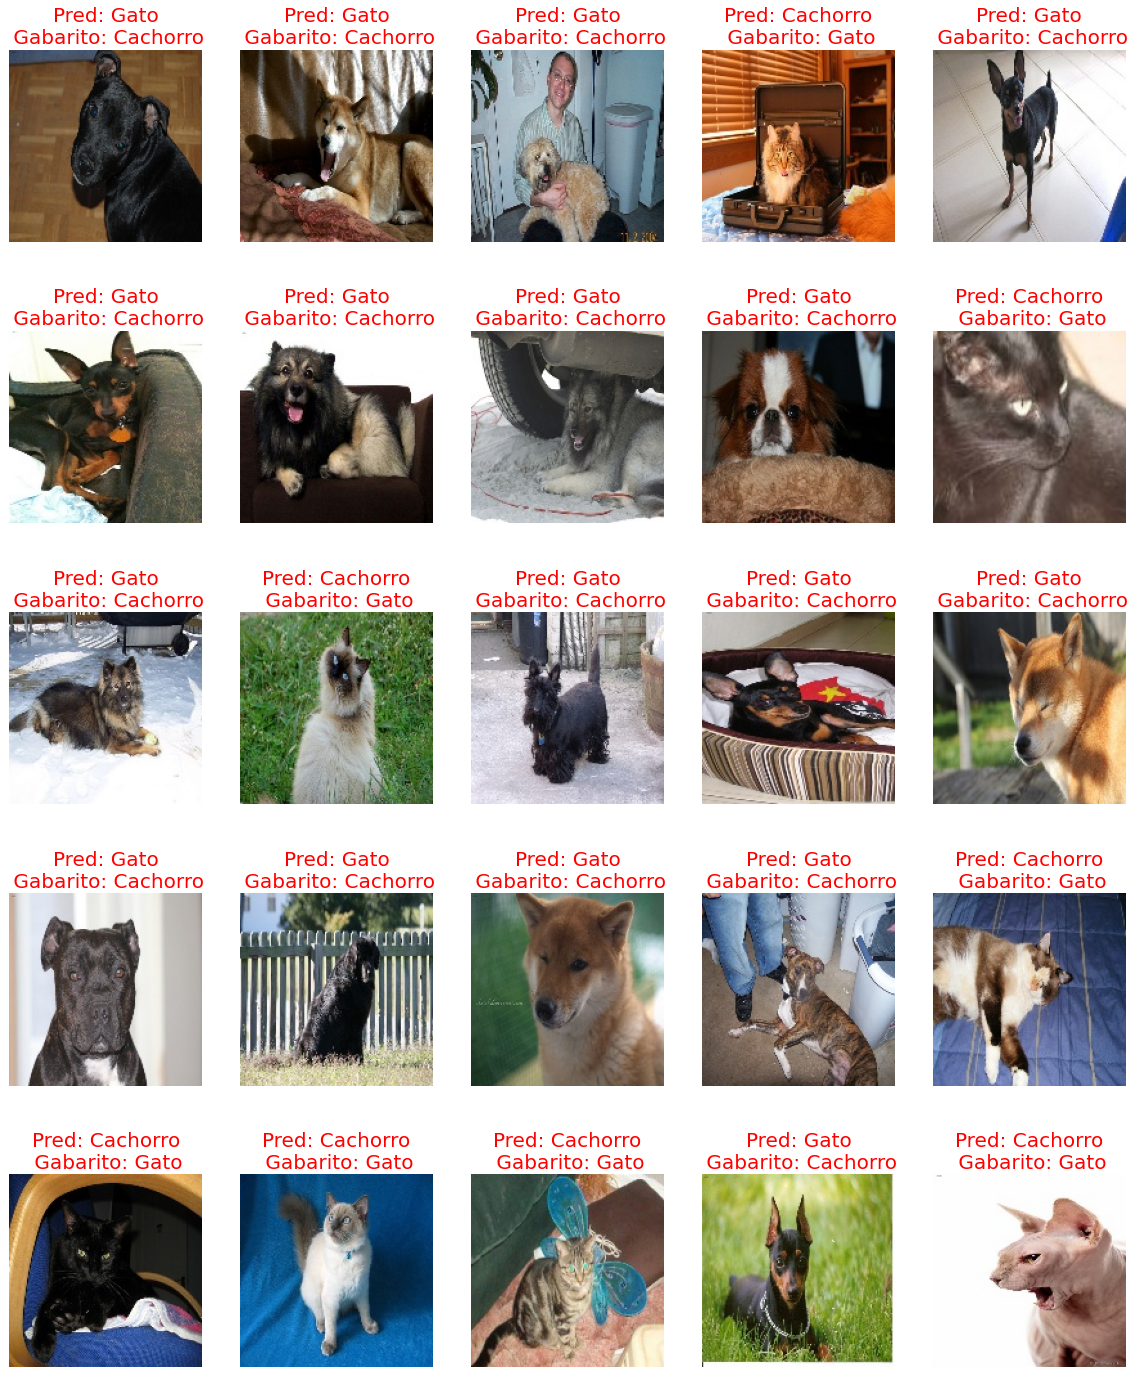

In [18]:
show_results(filenames, labels, preds, idx_to_class_dict, tipo = "erros")

***
![image](https://user-images.githubusercontent.com/58775072/160299668-eeb5f039-590c-4fcd-8b3f-8a74147992fc.gif)